In [50]:
!pip install sqlalchemy langgraph langchain langchain_aws langchain_community mypy_boto3_bedrock_runtime tavily-python langchain_fireworks langchain_together aiomysql


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00


In [52]:
import boto3

def get_bedrock_client():
    session = boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=os.environ["AWS_DEFAULT_REGION"]
    )
    client = session.client("bedrock-runtime")
    return client

In [53]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Optional
import operator
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_aws.chat_models import ChatBedrock
from langchain_core.callbacks import StreamingStdOutCallbackHandler
from mypy_boto3_bedrock_runtime.client import BedrockRuntimeClient
from pydantic import BaseModel, Field
from enum import Enum
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from tavily import TavilyClient
from typing import List

In [140]:
import logging
import sqlalchemy.engine

logging.getLogger("sqlalchemy.engine").setLevel(logging.WARNING)


In [54]:
class ModelKwargs(BaseModel):
    temperature: float = Field(default=0.1, ge=0, le=1)
    max_tokens: int = Field(default=2048, ge=1, le=4096)
    top_p: float = Field(default=0.999, ge=0, le=1)
    top_k: int = Field(default=0, ge=0, le=500)

class ModelKwargsMeta(BaseModel):
    temperature: float = Field(default=0.1, ge=0, le=1)
    max_tokens: int = Field(default=2048, ge=1, le=4096)
    top_p: float = Field(default=0.999, ge=0, le=1)

class ModelId(str, Enum):
    CLAUDE_3_HAIKU = "us.anthropic.claude-3-haiku-20240307-v1:0"
    CLAUDE_3_SONNET = "us.anthropic.claude-3-sonnet-20240229-v1:0"
    CLAUDE_3_OPUS = "us.anthropic.claude-3-opus-20240229-v1:0",
    CLAUDE_3_5_SONNET ="us.anthropic.claude-3-5-sonnet-20240620-v1:0"
    MISTRAL_7B_INSTRUCT ="us.mistral.mistral-7b-instruct-v0:2"
    LLAMA_3_3_70B ="us.meta.llama3-3-70b-instruct-v1:0"


In [55]:
def get_bedrock_model(
  client: BedrockRuntimeClient,
  model_id: ModelId,
  model_kwargs: ModelKwargs,
  streaming: bool = False,
  verbose: bool = False) -> ChatBedrock:
    return ChatBedrock(
        client=client,
        model_id=model_id.value,
        model_kwargs=model_kwargs.__dict__,
        streaming=streaming,
        verbose=verbose,
        callbacks=[StreamingStdOutCallbackHandler()] if streaming else []
    )

In [121]:
import asyncio
import os
from typing import List, Any
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
from sqlalchemy import MetaData,text


DB_URI = os.environ["SQL_DATABASE_URI"]

class DatabaseManager:
    def __init__(self):
        self.engine = create_async_engine(DB_URI, echo=True)
        self.Session = sessionmaker(
            bind=self.engine, class_=AsyncSession, expire_on_commit=False
        )

    async def get_schema(self) -> List[dict]:
        """Retrieve the database schema asynchronously."""
        async with self.engine.begin() as conn:
            metadata = MetaData()
            await conn.run_sync(metadata.reflect)
            schema = []
            for table in metadata.tables.values():
                table_info = {
                    "table_name": table.name,
                    "columns": [col.name for col in table.columns]
                }
                schema.append(table_info)

            return schema

    async def execute_query(self, query: str) -> List[Any]:
        """Execute SQL query asynchronously."""
        async with self.Session() as session:
            async with session.begin():
                result = await session.execute(text(query))
                return result.fetchall()


In [57]:
client = get_bedrock_client()
llm_generation=get_bedrock_model( client= client,model_id=ModelId.CLAUDE_3_SONNET,model_kwargs=ModelKwargs(),)

In [184]:
class RelevantTableSchema(BaseModel):
    table_name: str = Field(description="The name of the relevant table in the database.")
    columns: List[str] = Field(description="A list of column names that are relevant to the question.")
    noun_columns: List[str] = Field(description="A subset of 'columns' that represent key entities (nouns).")

class ParsedQuestionSchema(BaseModel):
    is_relevant: bool = Field(description="Indicates whether the question is relevant to the database.")
    relevant_tables: List[RelevantTableSchema] = Field(description="A list of relevant tables and their associated columns.")


class SqlQuerySchema(BaseModel):
    sql_query: str = Field(description="Generated SQL query based on user input and schema, ensuring proper formatting and filtering of NULL, 'N/A', or empty values.")


class SqlValidationSchema(BaseModel):
    sql_valid: bool = Field(description="Indicates whether the SQL query is valid.")
    sql_issues: Optional[str] = Field(description="Describes any issues found in the query, or null if there are no issues.")
    sql_query: str = Field(description="Generated SQL query based on user input and schema, ensuring proper formatting and filtering of NULL, 'N/A', or empty values.")


class VisualizationTypeEnum(str, Enum):
    BAR = "bar"
    HORIZONTAL_BAR = "horizontal_bar"
    LINE = "line"
    PIE = "pie"
    SCATTER = "scatter"
    NONE = "none"

class VisualizationRecommendationSchema(BaseModel):
    visualization: VisualizationTypeEnum = Field(description="The most suitable visualization type.")
    visualization_reason: str = Field(description="Brief explanation for the recommended visualization.")


In [185]:

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import HumanMessage, SystemMessage

db_manager = DatabaseManager()

async def parse_question(state: dict) -> dict:
  """Parse user question and identify relevant tables and columns."""
  question = state['question']
  schema = await db_manager.get_schema()
  system_prompt =(
      "You are a data analyst that specializes in understanding SQL databases and user queries. "
      "Your task is to analyze the given question and database schema to determine the relevant tables and columns. "
      "If the question is not related to the database or lacks sufficient information, mark it as irrelevant."
  )

  human_prompt = """
  Please analyze the provided database schema and user question to perform the following tasks:
  1. Identify if the question is relevant to the database schema.
  2. If relevant, determine the tables and columns that are necessary to answer the question from the database chema.
  3. Identify which columns contain meaningful noun-based information (for example - "Artist name" is relevant for "Top selling artists," but "Artist ID" is not).
  4. Present the results in a **parsable JSON format** without any additional text—only clean JSON output.
  5. If the question is irrelevant or lacks enough context, return `"is_relevant": false`.

  Here is the database schema:
  '''{schema}'''

  Here is the user question:
  '''{question}'''

  {format_instructions}
  """
  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=ParsedQuestionSchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser

  try:
      response = await chain.ainvoke(input={"question": question,"schema": schema,"format_instructions": parser.get_format_instructions()})
      print("response",response)
      return {"parsed_question": response}

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

def is_relevant_node(state: dict) -> bool:
  parsed_question = state['parsed_question']
  return parsed_question['is_relevant']

async def get_unique_nouns(state: dict) -> dict:
  """Find unique nouns in relevant tables and columns."""
  parsed_question = state['parsed_question']

  if not parsed_question['is_relevant']:
      return {"unique_nouns": []}

  unique_nouns = set()
  for table_info in parsed_question['relevant_tables']:
      table_name = table_info['table_name']
      noun_columns = table_info['noun_columns']

      if noun_columns:
          column_names = ', '.join(f"`{col}`" for col in noun_columns)
          query = f"SELECT DISTINCT {column_names} FROM `{table_name}`"
          results = await db_manager.execute_query(query)
          for row in results:
              unique_nouns.update(str(value) for value in row if value)

  return {"unique_nouns": list(unique_nouns)}

async def generate_sql(state: dict) -> dict:
  """Generate SQL query based on parsed question and unique nouns."""
  question = state['question']
  parsed_question = state['parsed_question']
  unique_nouns = state['unique_nouns']
  diagnostic_id = state['diagnostic_id']

  if not parsed_question['is_relevant']:
      return {"sql_query": "NOT_RELEVANT"}

  schema = await db_manager.get_schema()
  system_prompt = SystemMessage(
      "You are an AI assistant that generates SQL queries based on user questions, "
      "database schema, and unique nouns found in the relevant tables. Your task is to "
      "generate a valid SQL query that accurately answers the user's question.\n\n"
      "If there is insufficient information to construct a valid SQL query, respond with: **\"NOT_ENOUGH_INFO\"**.\n\n"
      "Ensure that all table and column names are enclosed in backticks. Skip rows where any column contains NULL, \"N/A\", or an empty string."
  )
  human_prompt = """
      Please analyze the provided database schema and user question, then generate an appropriate SQL query:

      1. Use the given database schema, relevant tables, and unique nouns to construct a valid SQL query.
      2. If insufficient information is available to form a query, return **"NOT_ENOUGH_INFO"** in **"sql_query"**.
      3. Ensure that all table and column names are enclosed in backticks (`).
      4. Skip all rows where any column contains "N/A", or an empty string.
      5. All queries must include `WHERE diagnostic_id = {diagnostic_id}`.
      6. Make sure to use the correct spellings of nouns as provided in the unique nouns list.
      7. The output should **only contain the SQL query string** with no additional text.

      ### **Examples:**
      1. For the customer data what was the bar plot between genders?
      Answer: SELECT `attribute_value`, COUNT(*) AS `count` FROM `customer_demographics` WHERE `attribute_name` LIKE '%gender%' AND `ref_id` IN (SELECT `id` FROM `customer_data` WHERE `diagnostic_id` = '670c9d8043060aec0379fdd6') AND (`attribute_value` IS NOT NULL AND `attribute_value` NOT IN ('', 'N/A')) GROUP BY `attribute_value` ORDER BY `count` DESC;

      2. What is the total revenue for each product?
      Answer: SELECT \`product name\`, SUM(quantity * price) as total_revenue FROM sales WHERE \`product name\` IS NOT NULL AND quantity IS NOT NULL AND price IS NOT NULL AND \`product name\` != "" AND quantity != "" AND price != "" AND \`product name\` != "N/A" AND quantity != "N/A" AND price != "N/A" GROUP BY \`product name\`  ORDER BY total_revenue DESC

      3. What is the market share of each product?
      Answer: SELECT \`product name\`, SUM(quantity) * 100.0 / (SELECT SUM(quantity) FROM sa  les) as market_share FROM sales WHERE \`product name\` IS NOT NULL AND quantity IS NOT NULL AND \`product name\` != "" AND quantity != "" AND \`product name\` != "N/A" AND quantity != "N/A" GROUP BY \`product name\`  ORDER BY market_share DESC

      4. Plot the distribution of income over time
      Answer: SELECT income, COUNT(*) as count FROM users WHERE income IS NOT NULL AND income != "" AND income != "N/A" GROUP BY income

      Here is the database schema:
      '''{schema}'''

      Here is the user question:
      '''{question}'''

      Here are the relevant tables and columns:
      '''{parsed_question}'''

      Here are the unique nouns found in the relevant tables:
      '''{unique_nouns}'''

      {format_instructions}
      """

  messages = [
        ("system", system_prompt.content),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=SqlQuerySchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser
  try:
      response = await chain.ainvoke(input={"question": question,"diagnostic_id": diagnostic_id,"schema": schema,"parsed_question": parsed_question,"unique_nouns": unique_nouns,"format_instructions": parser.get_format_instructions()})
      sql_query = response["sql_query"]
      if sql_query == "NOT_ENOUGH_INFO":
        return {"sql_query": "NOT_RELEVANT"}
      else:
        return {"sql_query": sql_query}

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

async def validate_and_fix_sql(state: dict) -> dict:
  """Validate and fix the generated SQL query."""
  sql_query = state['sql_query']

  if sql_query == "NOT_RELEVANT":
      return {"sql_query": "NOT_RELEVANT", "sql_valid": False}

  schema = await db_manager.get_schema()
  system_prompt = (
    "You are an AI assistant that validates and corrects SQL queries. Your tasks are:\n"
    "1. Verify if the SQL query is valid.\n"
    "2. Ensure table and column names match the given schema and are enclosed in backticks.\n"
    "3. If errors exist, return a corrected query; otherwise, return the original.\n"
  )

  human_prompt = """
    Analyze the following SQL query and database schema:

    **Database schema:**
    '''{schema}'''

    **SQL query:**
    '''{sql_query}'''

    Return a response in JSON format only.
    Here are examples:

    1. If the query is valid:
    {{
        "sql_valid": true,
        "sql_issues": null,
        "sql_query": "SELECT * FROM `users` WHERE `name` = 'John Doe'"
    }}

    2. If the query contains incorrect column names:
    {{
        "sql_valid": false,
        "sql_issues": "Column USERS does not exist",
        "sql_query": "SELECT * FROM `users` WHERE age > 25"
    }}

    3. If table/column names require backticks:
    {{
        "sql_valid": false,
        "sql_issues": "Column names should be enclosed in backticks if they contain spaces",
        "sql_query": "SELECT * FROM `gross income` WHERE `age` > 25"
    }}

    {format_instructions}
  """

  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=SqlValidationSchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser
  try:
      response = await chain.ainvoke(input={"sql_query": sql_query,"schema": schema,"format_instructions": parser.get_format_instructions()})
      if response["sql_valid"] and response["sql_issues"] is None:
        return {"sql_query": sql_query, "sql_valid": True}
      else:
        return {
            "sql_query": response["sql_query"],
            "sql_valid": response["sql_valid"],
            "sql_issues": response["sql_issues"]
        }

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")


async def execute_sql(state: dict) -> dict:
  """Execute SQL query and return results."""
  query = state['sql_query']

  if query == "NOT_RELEVANT":
      return {"results": "NOT_RELEVANT"}

  try:
      results = await db_manager.execute_query(query)
      return {"results": results}
  except Exception as e:
      return {"error": str(e)}

async def format_results(state: dict) -> dict:
  """Format query results into a human-readable response."""
  question = state['question']
  results = state['results']

  if results == "NOT_RELEVANT":
      return {"answer": "Sorry, I can only give answers relevant to the database."}
  system_prompt = (
      "You are an AI assistant that formats database query results into a human-readable response. "
      "Your task is to analyze the query results and generate a clear, concise conclusion based on the user's question. "
      "Ensure the response is directly relevant to the query results and provides a meaningful summary. "
      "Do not use markdown formatting or any additional text beyond the conclusion."
  )

  human_prompt = """
    Please analyze the provided query results and generate a human-readable conclusion based on the user's question.

    User question:
    '''{question}'''

    Query results:
    '''{results}'''
    """

  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation
  try:
      response = await chain.ainvoke(input={"question": question , "results": results })
      return {"answer": response.content}

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

async def choose_visualization(state: dict) -> dict:
  """Choose an appropriate visualization for the data."""
  question = state['question']
  results = state['results']
  sql_query = state['sql_query']

  if results == "NOT_RELEVANT":
      return {"visualization": "none", "visualization_reasoning": "No visualization needed for irrelevant questions."}

  system_prompt = (
    "You are an AI assistant that recommends appropriate data visualizations. "
    "Based on the user's question, SQL query, and query results, suggest the most suitable type of graph or chart to visualize the data. "
    "If no visualization is appropriate, indicate 'none'. "
    "Ensure that the recommended chart type aligns with the nature of the data and the question's intent."
    "ONLY use the following names for chart types: bar, horizontal_bar, line, pie, scatter, none."
    "Present the results in a **parsable JSON format** without any additional text—only clean JSON output."
)

  human_prompt = """
      Analyze the provided user question, SQL query, and query results to recommend the most suitable visualization.

      Available chart types and use cases:
      - **bar**: Compare categorical data or show changes over time with more than 2 categories.
        *Example: "What are the sales figures for each product?"*
      - **horizontal_bar**: Compare categorical data when the number of categories is small or disparities are large.
        *Example: "How does the population of 2 cities compare?"*
      - **scatter**: Identify relationships or distributions between two numerical variables.
        *Example: "Is there a correlation between marketing spend and revenue?"*
      - **pie**: Show proportions or percentages within a whole.
        *Example: "What percentage of the total revenue comes from each product?"*
      - **line**: Show trends and distributions over time.
        *Example: "What is the trend in temperature over the past decade?"*
      - **none**: If no visualization is appropriate.

      Consider these types of questions when recommending a visualization:
      1. **Aggregations and Summarizations** (e.g., "What is the average revenue by month?" → **line**)
      2. **Comparisons** (e.g., "Compare sales figures of Product A and Product B" → **line** or **bar**)
      3. **Plotting Distributions** (e.g., "Plot a distribution of ages" → **scatter**)
      4. **Trends Over Time** (e.g., "What is the trend in active users over time?" → **line**)
      5. **Proportions** (e.g., "What is the market share?" → **pie**)
      6. **Correlations** (e.g., "Is there a correlation between X and Y?" → **scatter**)

      User question:
      '''{question}'''

      SQL query:
      '''{sql_query}'''

      Query results:
      '''{results}'''

      {format_instructions}
"""
  messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
  parser = JsonOutputParser(pydantic_object=VisualizationRecommendationSchema)
  chat_prompt = ChatPromptTemplate.from_messages(messages)
  chain = chat_prompt | llm_generation | parser
  try:
      response = await chain.ainvoke(input={"sql_query": sql_query,"results": results,"question": question ,"format_instructions": parser.get_format_instructions()})
      return {
            "visualization": response["visualization"],
            "visualization_reason": response["visualization_reason"],
              }

  except Exception as e:
      print("An unexpected error occurred:", e)
      raise RuntimeError(f"Error fetching the data: {str(e)}")

In [186]:
from typing import List, Any, Annotated, Dict, Optional
from typing_extensions import TypedDict
import operator

class InputState(TypedDict):
    question: str
    diagnostic_id: str
    parsed_question: Dict[str, Any]
    unique_nouns: List[str]
    sql_query: str
    results: List[Any]
    visualization: Annotated[str, operator.add]

class OutputState(TypedDict):
    parsed_question: Dict[str, Any]
    unique_nouns: List[str]
    sql_query: str
    sql_valid: bool
    sql_issues: str
    results: List[Any]
    answer: Annotated[str, operator.add]
    error: str
    visualization: Annotated[str, operator.add]
    visualization_reason: Annotated[str, operator.add]
    formatted_data_for_visualization: Dict[str, Any]

In [181]:

from langgraph.graph import StateGraph
from langgraph.graph import END

class WorkflowManager:
    def __init__(self):
        ...

    def create_workflow(self) -> StateGraph:
        """Create and configure the workflow graph."""
        workflow = StateGraph(input=InputState, output=OutputState)

        workflow.add_node("parse_question", parse_question)
        workflow.add_node("get_unique_nouns", get_unique_nouns)
        workflow.add_node("generate_sql", generate_sql)
        workflow.add_node("validate_and_fix_sql", validate_and_fix_sql)
        workflow.add_node("execute_sql", execute_sql)
        workflow.add_node("format_results", format_results)
        workflow.add_node("choose_visualization", choose_visualization)
        workflow.add_conditional_edges("parse_question",is_relevant_node, {True: "get_unique_nouns", False: END})
        workflow.add_edge("get_unique_nouns", "generate_sql")
        workflow.add_edge("generate_sql", "validate_and_fix_sql")
        workflow.add_edge("validate_and_fix_sql", "execute_sql")
        workflow.add_edge("execute_sql", "format_results")
        workflow.add_edge("execute_sql", "choose_visualization")
        workflow.add_edge("choose_visualization", END)
        workflow.add_edge("format_results", END)
        workflow.set_entry_point("parse_question")

        return workflow

    def returnGraph(self):
        return self.create_workflow().compile()

    def run_sql_agent(self, question: str, diagnostic_id: str) -> dict:
        """Run the SQL agent workflow and return the formatted answer and visualization recommendation."""
        app = self.create_workflow().compile()
        result = app.invoke({"question": question,"diagnostic_id":diagnostic_id})
        return {
            "answer": result['answer'],
            "visualization": result['visualization'],
            "visualization_reason": result['visualization_reason'],
        }


In [187]:
graph = WorkflowManager()
runnable = graph.returnGraph()


<ipython-input-181-9513e0ac0c26>:10: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  workflow = StateGraph(input=InputState, output=OutputState)


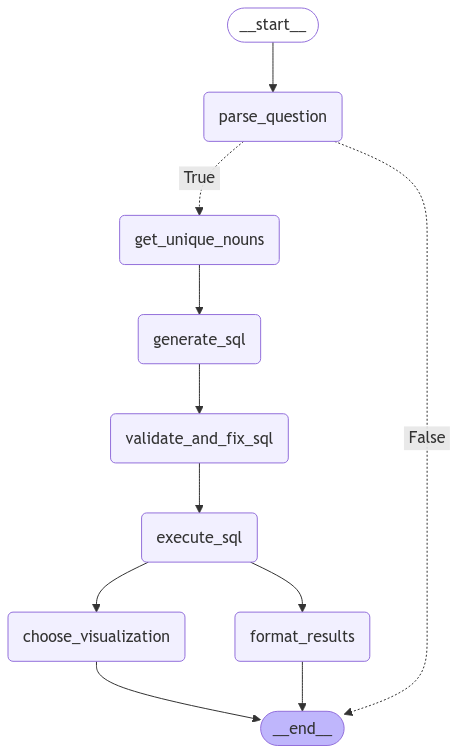

In [152]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
out = await runnable.ainvoke({
    "question": "For the customer what are various demographic data available",
    "diagnostic_id": "670d79a708cd96a9c3b69568",})

In [203]:
print(out["answer"])

The query results indicate that the only demographic data available for the customer is their age group, which is 11.
